### HW 5: CNNs, AEs, GAN

In [1]:
import glob
import os
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
import numpy as np
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, random_split
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

#### Task 1 Part 1
The dataset being used is the pistachio image dataset located at https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset. The goal is to classify the given pistachio images as being either Kirmizi or Siirt pistachios.

Read in Images as greyscale and normalized.

In [2]:
os.chdir("../../PIML/HW5/kirmizi")

In [3]:
kirmizi_names = [file for file in glob.glob("*.jpg")]
kirmizi_images  = np.array([cv2.resize(cv2.imread(name), (64, 64))/255 for name in kirmizi_names])
print(kirmizi_images.shape)

(1232, 64, 64, 3)


In [4]:
os.chdir("../siirt")

In [5]:
siirt_names = [file for file in glob.glob("*jpg")]
siirt_images = np.array([cv2.resize(cv2.imread(name), (64, 64))/255 for name in siirt_names])
print(siirt_images.shape)

(916, 64, 64, 3)


Preprocess and view the images.

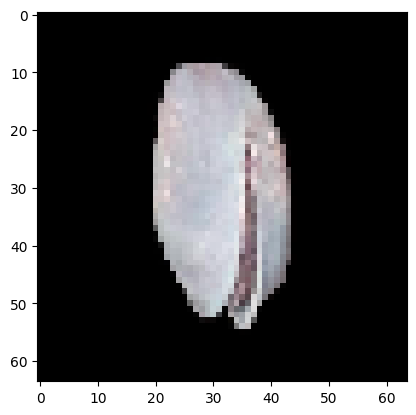

In [6]:
plt.imshow(kirmizi_images[0], cmap = "gray")

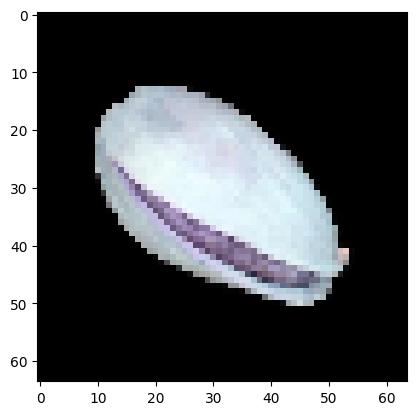

In [7]:
plt.imshow(siirt_images[0], cmap = "gray" )

In [8]:
# Generate Data and Labels
p_img = np.vstack((kirmizi_images, siirt_images))
labels = np.zeros(p_img.shape[0])
labels[:kirmizi_images.shape[0]] = 1
print(p_img.shape, labels.shape)

(2148, 64, 64, 3) (2148,)


Initialize the Dataloader

In [9]:
class PistachioData(du.Dataset):
    """
    Represents the pistachio image dataset and
    passes images by batch during model training.
    """
    def __init__(self, p_img, labels):
        super(PistachioData, self).__init__()
        self.images = p_img
        self.labels = labels
    
    def __len__(self):
        return self.labels.shape[0]
        
    def __getitem__(self, idx):
        context = torch.tensor(self.images[idx])
        labels = torch.tensor(self.labels[idx])
        
        return context, labels

Create a Convolutional Model

I decided to use a simple 3 layer CNN model to better demonstrate the effects of data augmentation on training accuracy.

In [10]:
class CNN(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, hidden_dim, out_dim):
        super(CNN, self).__init__()
        
        # initialize CNN network
        self.CNN_R = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size, bias = True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(out_channel, 2 * out_channel, kernel_size, bias = True),
        )
        
        # initialize dense layers
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(5832, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.dropout = nn.Dropout()
        
    def forward(self, x):
        
        # pass through CNN
        x = self.CNN_R(x)
        
        # flatten and pass through mlp
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

Initialize training parameters

In [11]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using {device}")

epochs = 10
learning_rate = 0.07
batch_size = 128
in_channel = 3
out_channel = 4
kernel_size = 4
hidden_dim = 128
out_dim = 1

using cpu


Initialize Model, Dataloader, and Optimizer

In [12]:
#split data into train, test, and validation.
train_data, train_other, label_data, label_other = train_test_split(p_img, labels, test_size = 0.25)
valid_data, test_data, valid_label, test_label = train_test_split(train_other, label_other, test_size = 0.4)

print(f"Train: {train_data.shape}, {label_data.shape}")
print(f"Validation: {valid_data.shape}, {valid_label.shape}")
print(f"Test: {test_data.shape}, {test_label.shape}")

#initialize datasets
train_data = PistachioData(train_data, label_data)
valid_data = PistachioData(valid_data, valid_label)
test_data = PistachioData(test_data, test_label)

#set up the dataloader
train_loader = du.DataLoader(dataset=train_data,
                             batch_size=batch_size,
                             shuffle=True)
valid_loader = du.DataLoader(dataset=valid_data,
                             batch_size=batch_size,
                             shuffle=True)
test_loader = du.DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             shuffle=True)

Train: (1611, 64, 64, 3), (1611,)
Validation: (322, 64, 64, 3), (322,)
Test: (215, 64, 64, 3), (215,)


In [13]:
#Initialize the Model
net = CNN(in_channel, out_channel, kernel_size, hidden_dim, out_dim)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

#send the model to the device
net = net.to(device)
net.train()

CNN(
  (CNN_R): Sequential(
    (0): Conv2d(3, 4, kernel_size=(4, 4), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(4, 8, kernel_size=(4, 4), stride=(1, 1))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=5832, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Train the Model and Evaluate on Validation

In [14]:
loss_func = nn.BCEWithLogitsLoss()

for epoch in range(1, epochs+1):
    sum_loss = 0.
    for batch_idx, (contexts, targets) in enumerate(train_loader):
        
        optimizer.zero_grad()
        contexts, targets = contexts.to(device), targets.to(device)
        contexts = contexts.transpose(3,1).float()
        
        # run the forward pass
        preds = net(contexts)
        
        # evaluate loss
        loss = loss_func(preds.squeeze().float(), targets.float())
        sum_loss += loss.item()
        
        # backpropagate
        loss.backward()
        optimizer.step()
    
    print(f"Epoch: {epoch}, Training Loss: {sum_loss/len(train_data):.6f}")

Epoch: 1, Training Loss: 8.171589
Epoch: 2, Training Loss: 1.410534
Epoch: 3, Training Loss: 0.005548
Epoch: 4, Training Loss: 0.005489
Epoch: 5, Training Loss: 0.005486
Epoch: 6, Training Loss: 0.005497
Epoch: 7, Training Loss: 0.005482
Epoch: 8, Training Loss: 0.005496
Epoch: 9, Training Loss: 0.005496
Epoch: 10, Training Loss: 0.005487


Evaluate on the validation set

In [15]:
# evaluate on the validation set
net.eval()
with torch.no_grad():
    val_corr = 0
    for (context, targets) in valid_loader:

        context, targets = context.to(device), targets.to(device)
        context = context.transpose(3,1).float()
        targets = targets.unsqueeze(-1)

        preds = net(context)

        #evaluate correct predictions
        preds = F.softmax(preds, dim = 1)
        val_corr += torch.sum(preds == targets)
        
    print(f"Validation Accuracy: {val_corr/len(test_data):.6f}")

Validation Accuracy: 0.827907


Evaluate the model on the test data

In [16]:
with torch.no_grad():
    num_corr = 0
    for (context, targets) in test_loader:

        context, targets = context.to(device), targets.to(device)
        context = context.transpose(3,1).float()
        targets = targets.unsqueeze(-1)

        preds = net(context)

        #evaluate correct predictions
        preds = F.softmax(preds, dim = 1)
        num_corr += torch.sum(preds == targets)
        
    print(f"Testing Accuracy: {num_corr/len(test_data):.6f}")

Testing Accuracy: 0.553488


#### Final Evaluation:
We see that the CNN learns well on the training set but does not generalize as well on the testing and validation set. This is likely due to the small scale of the CNN network being used.

### Part 2: Transfer Learning:
For this part, we will transfer learn from MobileNet.

In [17]:
from torchvision.models import mobilenet_v2
from torchvision.models import MobileNet_V2_Weights

In [18]:
# load the pretrained mobile net.
mb_net = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

#disable gradients
for p in mb_net.parameters():
    p.requires_grad = False
mb_net.to(device)
mb_net.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Initialize dense layers for the MobileNet.

In [19]:
class Dense(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(Dense, self).__init__()
        
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, x):
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

In [20]:
d_net = Dense(1000, hidden_dim, out_dim)
optimizer = optim.Adam(d_net.parameters(), lr = learning_rate)

d_net.to(device)
d_net.train()

Dense(
  (fc1): Linear(in_features=1000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [21]:
# Train the dense layers
loss_func = nn.BCEWithLogitsLoss()

for epoch in range(1, epochs+1):
    sum_loss = 0.
    for batch_idx, (contexts, targets) in enumerate(train_loader):
        
        optimizer.zero_grad()
        contexts, targets = contexts.to(device), targets.to(device)
        contexts = contexts.transpose(3,1).float()
        
        # run the forward pass
        preds = mb_net(contexts)
        preds = d_net(preds)
        
        # evaluate loss
        loss = loss_func(preds.squeeze().float(), targets.float())
        sum_loss += loss.item()
        
        # backpropagate
        loss.backward()
        optimizer.step()
    
    print(f"Epoch: {epoch}, Training Loss: {sum_loss/len(train_data):.6f}")

Epoch: 1, Training Loss: 0.234112
Epoch: 2, Training Loss: 0.005068
Epoch: 3, Training Loss: 0.004184
Epoch: 4, Training Loss: 0.003846
Epoch: 5, Training Loss: 0.003538
Epoch: 6, Training Loss: 0.003210
Epoch: 7, Training Loss: 0.003079
Epoch: 8, Training Loss: 0.003045
Epoch: 9, Training Loss: 0.002717
Epoch: 10, Training Loss: 0.002659


In [22]:
# evaluate on the validation set
d_net.eval()
with torch.no_grad():
    val_corr = 0
    for (context, targets) in valid_loader:

        context, targets = context.to(device), targets.to(device)
        context = context.transpose(3,1).float()
        targets = targets.unsqueeze(-1)
        
        preds = mb_net(context)
        preds = d_net(preds)

        #evaluate correct predictions
        preds = F.softmax(preds, dim = 1)
        val_corr += torch.sum(preds == targets)
        
    print(f"Validation Accuracy: {val_corr/len(test_data):.6f}")

Validation Accuracy: 0.827907


In [23]:
# evaluate on test set
with torch.no_grad():
    num_corr = 0
    for (context, targets) in test_loader:

        context, targets = context.to(device), targets.to(device)
        context = context.transpose(3,1).float()
        targets = targets.unsqueeze(-1)

        preds = mb_net(context)
        preds = d_net(preds)

        #evaluate correct predictions
        preds = F.softmax(preds, dim = 1)
        num_corr += torch.sum(preds == targets)
        
    print(f"Testing Accuracy: {num_corr/len(test_data):.6f}")

Testing Accuracy: 0.553488


### Part 3: Data Augmentation:
For this part, the pistachio data was augmented through random image rotations in an attempt to improve accuracy.

In [24]:
# Apply data augmentation with a 75% probability.
for p in p_img:
    op = np.random.choice([1,2,3,4])
    if op == 2:
        p = cv2.rotate(p, cv2.ROTATE_90_CLOCKWISE)
    elif op == 3:
        p = cv2.rotate(p, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif op == 4:
        p = cv2.flip(p, -1)

Repeat the training done in part 1.

In [25]:
# Remake the dataloaders
train_data, train_other, label_data, label_other = train_test_split(p_img, labels, test_size = 0.25)
valid_data, test_data, valid_label, test_label = train_test_split(train_other, label_other, test_size = 0.4)

print(f"Train: {train_data.shape}, {label_data.shape}")
print(f"Validation: {valid_data.shape}, {valid_label.shape}")
print(f"Test: {test_data.shape}, {test_label.shape}")

#initialize datasets
train_data = PistachioData(train_data, label_data)
valid_data = PistachioData(valid_data, valid_label)
test_data = PistachioData(test_data, test_label)

#set up the dataloader
train_loader = du.DataLoader(dataset=train_data,
                             batch_size=batch_size,
                             shuffle=True)
valid_loader = du.DataLoader(dataset=valid_data,
                             batch_size=batch_size,
                             shuffle=True)
test_loader = du.DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             shuffle=True)

Train: (1611, 64, 64, 3), (1611,)
Validation: (322, 64, 64, 3), (322,)
Test: (215, 64, 64, 3), (215,)


In [26]:
# Reinitialize the model
net = CNN(in_channel, out_channel, kernel_size, hidden_dim, out_dim)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

#send the model to the device
net = net.to(device)
net.train()

CNN(
  (CNN_R): Sequential(
    (0): Conv2d(3, 4, kernel_size=(4, 4), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(4, 8, kernel_size=(4, 4), stride=(1, 1))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=5832, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [27]:
loss_func = nn.BCEWithLogitsLoss()

for epoch in range(1, epochs+1):
    sum_loss = 0.
    for batch_idx, (contexts, targets) in enumerate(train_loader):
        
        optimizer.zero_grad()
        contexts, targets = contexts.to(device), targets.to(device)
        contexts = contexts.transpose(3,1).float()
        
        # run the forward pass
        preds = net(contexts)
        
        # evaluate loss
        loss = loss_func(preds.squeeze().float(), targets.float())
        sum_loss += loss.item()
        
        # backpropagate
        loss.backward()
        optimizer.step()
    
    print(f"Epoch: {epoch}, Training Loss: {sum_loss/len(train_data):.6f}")

Epoch: 1, Training Loss: 4.611070
Epoch: 2, Training Loss: 0.031187
Epoch: 3, Training Loss: 0.005827
Epoch: 4, Training Loss: 0.005529
Epoch: 5, Training Loss: 0.005541
Epoch: 6, Training Loss: 0.005530
Epoch: 7, Training Loss: 0.005531
Epoch: 8, Training Loss: 0.005533
Epoch: 9, Training Loss: 0.005530
Epoch: 10, Training Loss: 0.005531


In [28]:
# evaluate on the validation set
net.eval()
with torch.no_grad():
    val_corr = 0
    for (context, targets) in valid_loader:

        context, targets = context.to(device), targets.to(device)
        context = context.transpose(3,1).float()
        targets = targets.unsqueeze(-1)

        preds = net(context)

        #evaluate correct predictions
        preds = F.softmax(preds, dim = 1)
        val_corr += torch.sum(preds == targets)
        
    print(f"Validation Accuracy: {val_corr/len(test_data):.6f}")

Validation Accuracy: 0.920930


In [29]:
with torch.no_grad():
    num_corr = 0
    for (context, targets) in test_loader:

        context, targets = context.to(device), targets.to(device)
        context = context.transpose(3,1).float()
        targets = targets.unsqueeze(-1)

        preds = net(context)

        #evaluate correct predictions
        preds = F.softmax(preds, dim = 1)
        num_corr += torch.sum(preds == targets)
        
    print(f"Testing Accuracy: {num_corr/len(test_data):.6f}")

Testing Accuracy: 0.600000


#### Results:
We see that the validation accuracy is slightly lower after training on the augmented dataset while the testing accuracy is slightly higher. Overall, there is not much difference though the augmented data does have higher accuracy overall. This suggests that the applied augmentation methods did not impact the model's accuracy as much as expected.

### Task 2: VAE and GANs

#### Part 1: Variational Autoencoder
For this task, I will also be using the pistachio dataset from part 1 and will be using the model implemented at https://www.tensorflow.org/tutorials/generative/cvae.

Load the dataset and create the DataLoader. For this part, I will be using the fashion MNIST dataset.

In [30]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.EMNIST(data_dir, 'letters', train=True, download=True)

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset.transform = train_transform

m=len(train_dataset)

training_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
training_data = torch.utils.data.DataLoader(train_data, batch_size=64)

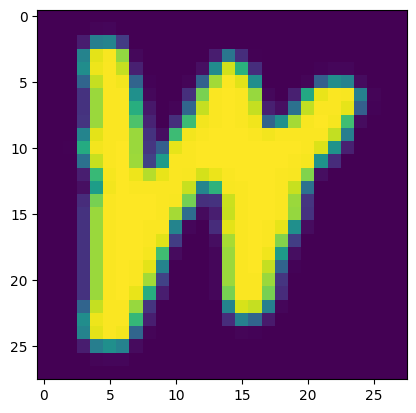

In [31]:
plt.imshow(torch.transpose(train_dataset[0][0], 0, 2))

In [32]:
class CVAE(nn.Module):
    def __init__(self, latent_dim, in_channels):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder Architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=(2, 2)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, kernel_size=3, stride=(2, 2)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=(2, 2)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(128, 256, kernel_size=3, stride=(2, 2)),
            nn.BatchNorm2d(256),
            nn.Flatten(),
            nn.Linear(2304, 512),
            nn.ReLU(),
            nn.Linear(512, 256)
        )

        # Decoder Architecture
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(32, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.Sigmoid()
        )

        self.mean, self.logvar, self.fc = nn.Linear(256, latent_dim), nn.Linear(256, latent_dim), nn.Linear(latent_dim, 8192)
    
    def encode(self, x):
        x = self.encoder(x)
        mean = self.mean(x)
        logvar = self.logvar(x)
        return mean, logvar

    def decode(self, x):
        x = torch.reshape(self.fc(x), (-1, 512, 4, 4))
        x = self.decoder(x)
        return x

    def reparameterize(self, mean, logvar):
        sd = torch.exp(0.5 * logvar)
        eps = torch.randn_like(sd)
        return sd * mean + eps

    def sample(self, x):
        return self.decode(x)

    def forward(self, x):
        m, l = self.encode(x)
        rp = self.reparameterize(m, l)
        o = self.decode(rp)
        return o, m, l

Initialize VAE parameters

In [33]:
epochs = 5
in_channels = 3
batch_size = 64
latent_dim = 128
learning_rate = 0.0007

Initialize VAE model

In [34]:
vae_model = CVAE(latent_dim, in_channels)
optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate, weight_decay=1e-5)
vae_model.to(device)
vae_model.train()

CVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Dropout(p=0.3, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=2304, out_features=512, bias=True)
    (15): ReLU()
    (16): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512

Train and Visualize VAE images

26it [00:33,  1.30s/it]


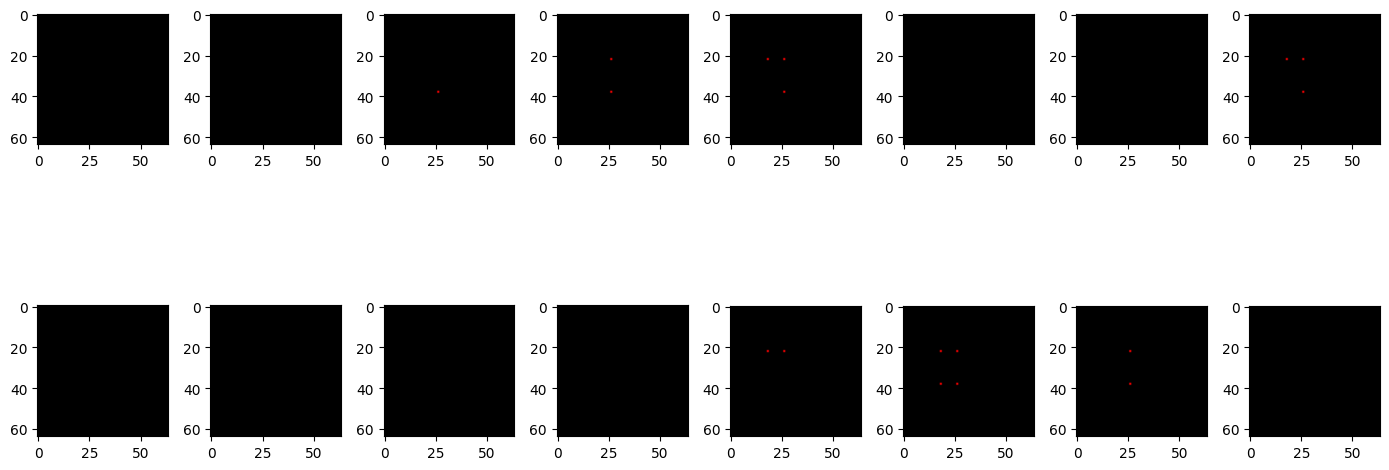

0it [00:00, ?it/s]

Epoch: 1, Training Loss: 9282.411715


26it [00:36,  1.41s/it]


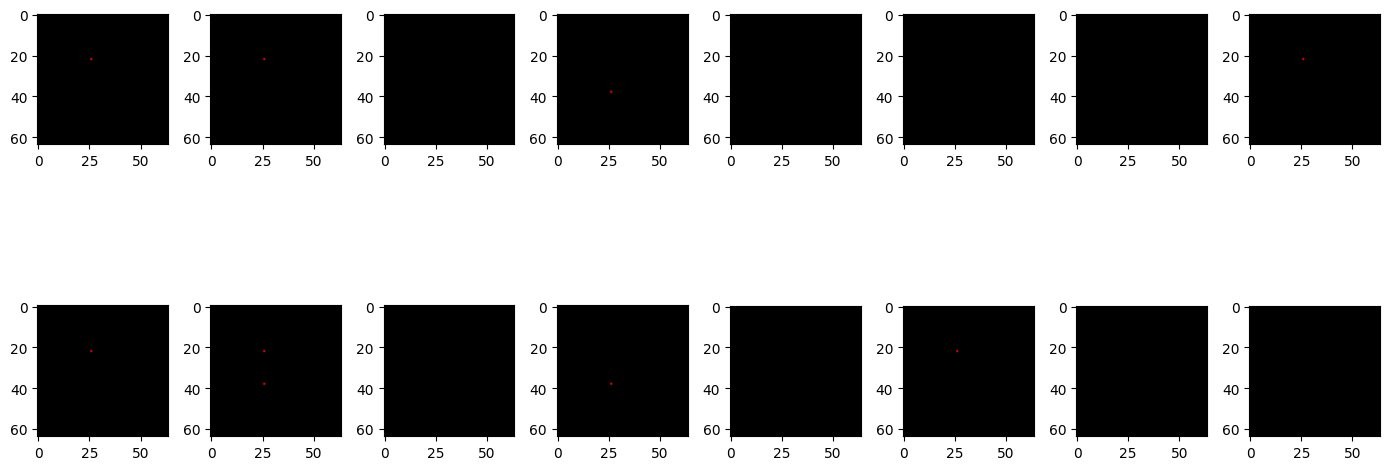

0it [00:00, ?it/s]

Epoch: 2, Training Loss: 8540.082960


26it [00:33,  1.30s/it]


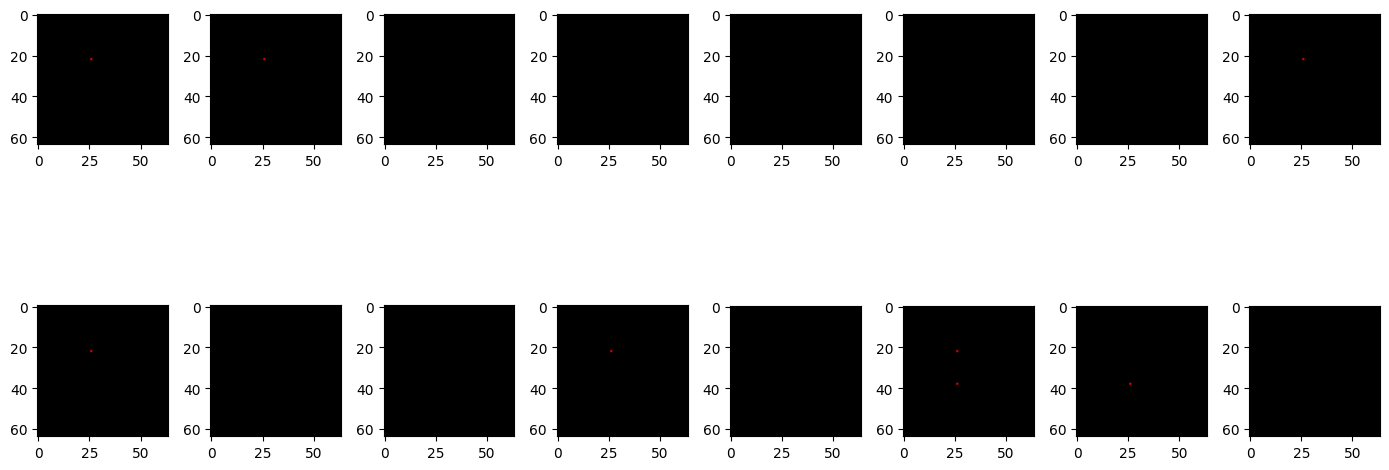

0it [00:00, ?it/s]

Epoch: 3, Training Loss: 8357.364690


26it [00:33,  1.30s/it]


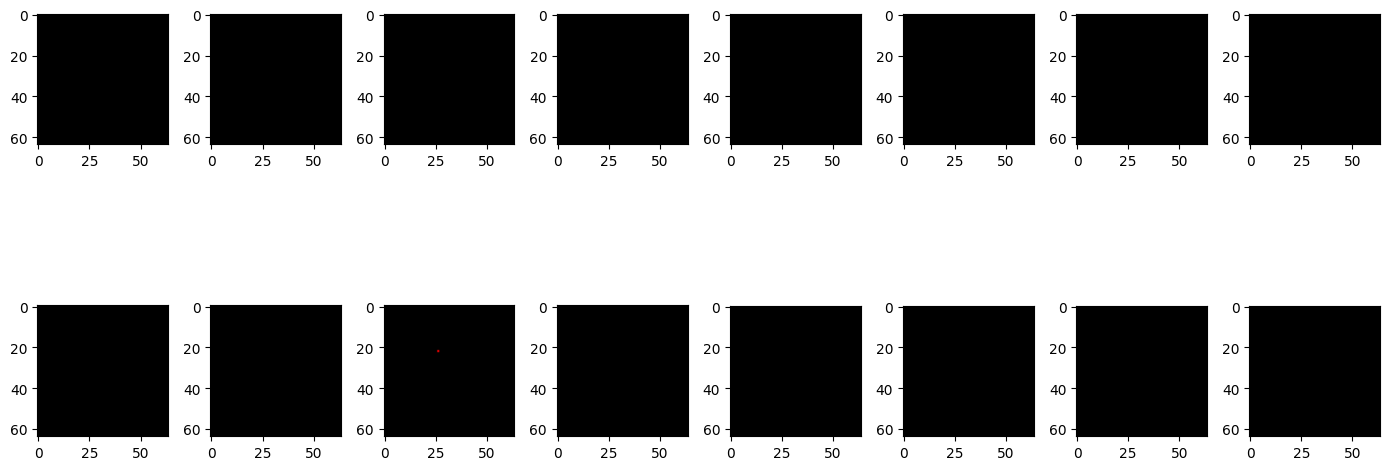

0it [00:00, ?it/s]

Epoch: 4, Training Loss: 8403.128744


26it [00:29,  1.15s/it]


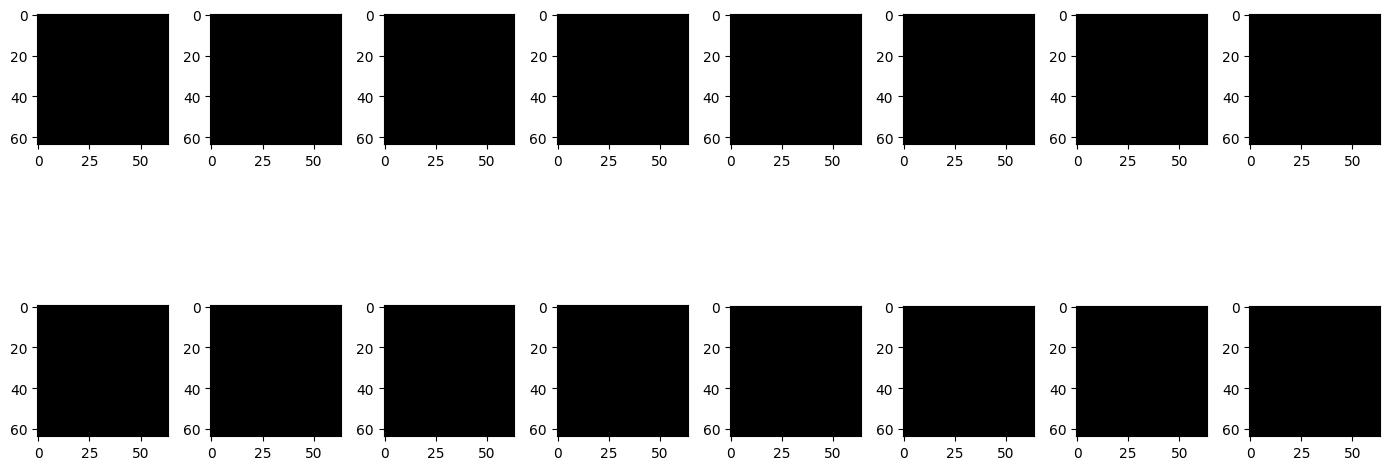

Epoch: 5, Training Loss: 8196.171215


In [35]:
for epoch in range(1, epochs + 1):
    vae_model.train()
    sum_loss = 0.
    
    # train the model
    for batch_idx, (contexts, targets) in tqdm(enumerate(training_data)):
        
        targets = torch.as_tensor(targets)
        
        optimizer.zero_grad()
        contexts, targets = contexts.to(device), targets.to(device)
        contexts = (contexts.transpose(3, 1)/255).float()
        
        # run the forward pass
        o, m, l = vae_model(contexts.float())
        
        # evaluate loss
        loss = F.binary_cross_entropy(o, contexts, reduction="sum")
        logs = -torch.sum(1 + torch.log(l.pow(2)) - m.pow(2) - l.pow(2))
        loss += logs
        sum_loss += loss.item()
        
        # backpropagate
        loss.backward()
        optimizer.step()
    
    # visualize training results
    vae_model.eval()
    
    with torch.no_grad():
        out = vae_model.sample(torch.randn(16, latent_dim, device=device)).detach()
        out = torch.transpose(out, 1, 3)
        out = out.to(torch.uint8)

        rows, columns = 2, 8
        fig = plt.figure(figsize=(14, 7))

        for i in range(1, out.shape[0]+1):
            fig.add_subplot(rows, columns, i)
            plt.imshow(out[i-1]*255)

        plt.tight_layout()
        plt.show()
    
    print(f"Epoch: {epoch}, Training Loss: {sum_loss/len(train_data):.6f}")

Evaluate final results

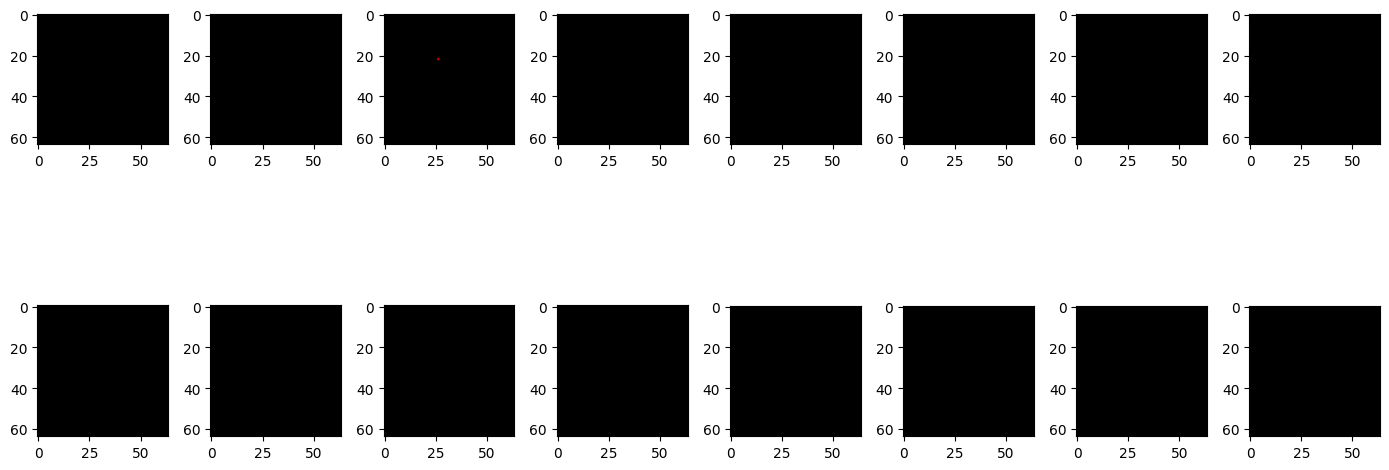

In [36]:
out = vae_model.sample(torch.randn(16, latent_dim, device=device)).detach()
out = torch.transpose(out, 1, 3)
out = out.to(torch.uint8)

rows, columns = 2, 8
fig = plt.figure(figsize=(14, 7))

for i in range(1, out.shape[0]+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(out[i-1]*255)

plt.tight_layout()

#### Part 2: GANs
For this part, I will be implementing the GANs architechture used at https://www.tensorflow.org/tutorials/generative/dcgan with the same pistachio dataset as in part 1.

In [37]:
class Discriminator(nn.Module):
    def __init__(self, in_channel, hidden_dim):
        super(Discriminator, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channel, hidden_dim, 4, 2, 1),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(hidden_dim, hidden_dim * 2, 4, 2, 1),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 4, 2, 1),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(hidden_dim * 4, hidden_dim * 8, 4, 2, 1),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(hidden_dim * 8, 1, 4, 2, 0),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)
    
class Generator(nn.Module):
    def __init__(self, in_channel, hidden_dim, out_dim):
        super(Generator, self).__init__()
        
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_channel, hidden_dim * 16, 4, 1, 0),
            nn.BatchNorm2d(hidden_dim * 16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(hidden_dim * 16, hidden_dim * 8, 4, 2, 1),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(hidden_dim * 8, hidden_dim * 4, 4, 2, 1),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, 4, 2, 1),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(hidden_dim * 2, out_dim, 4, 2, 1),
            nn.Tanh(),
        )
    
    def forward(self, x):
        return self.layers(x)

Initialize Weights and Model

In [38]:
def w_init(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0., 0.02)

In [39]:
epochs = 5
batch_size = 32
learning_rate = 0.0007
in_channel = 100
out_channel = 3
hidden_dim = 64

# Initialize Models
gen = Generator(in_channel, hidden_dim, out_channel)
dc = Discriminator(out_channel, hidden_dim)

g_optimizer = optim.Adam(gen.parameters(), lr = learning_rate, betas = (0.5, 0.999))
d_optimizer = optim.Adam(dc.parameters(), lr = learning_rate, betas = (0.5, 0.999))

# Set to training mode and initialize weights
gen, dc = gen.to(device), dc.to(device)
w_init(gen)
w_init(dc)
gen.train()
dc.train()

Discriminator(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.3, inplace=False)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2)
    (15): Conv2d(512

Train the model

13it [02:08,  9.87s/it]


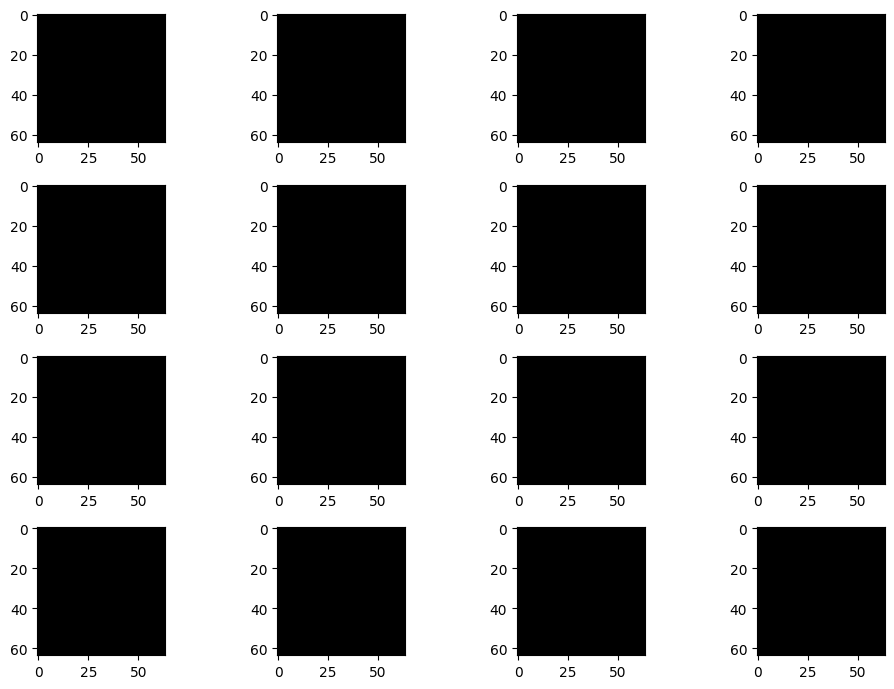

0it [00:00, ?it/s]

Epoch: 1, Gen Loss: 0.001790, Discriminator Loss: 0.004402


13it [01:41,  7.80s/it]


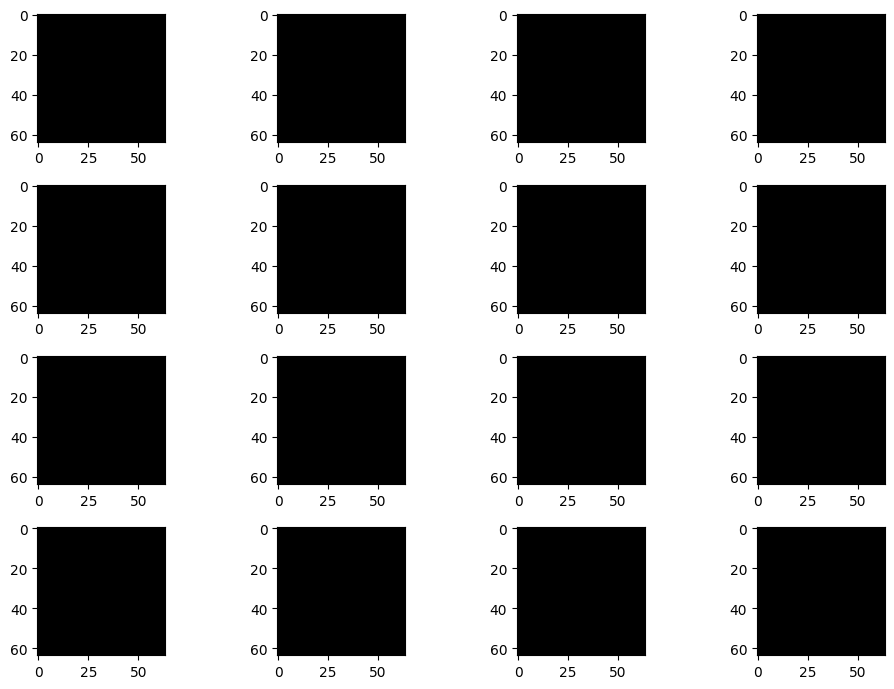

0it [00:00, ?it/s]

Epoch: 2, Gen Loss: 0.000213, Discriminator Loss: 0.000491


13it [01:42,  7.91s/it]


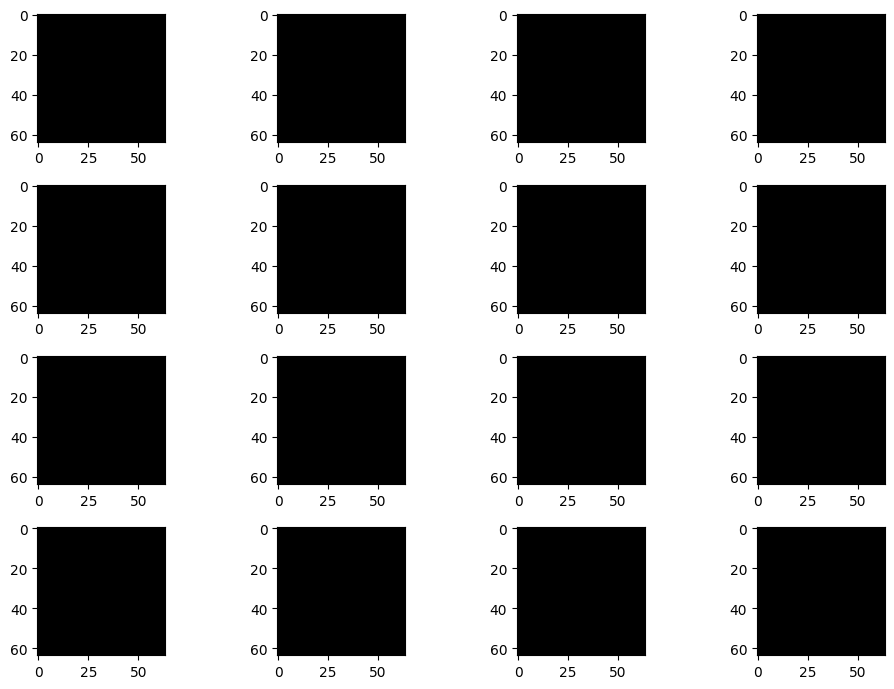

0it [00:00, ?it/s]

Epoch: 3, Gen Loss: 0.000071, Discriminator Loss: 0.000157


13it [01:46,  8.21s/it]


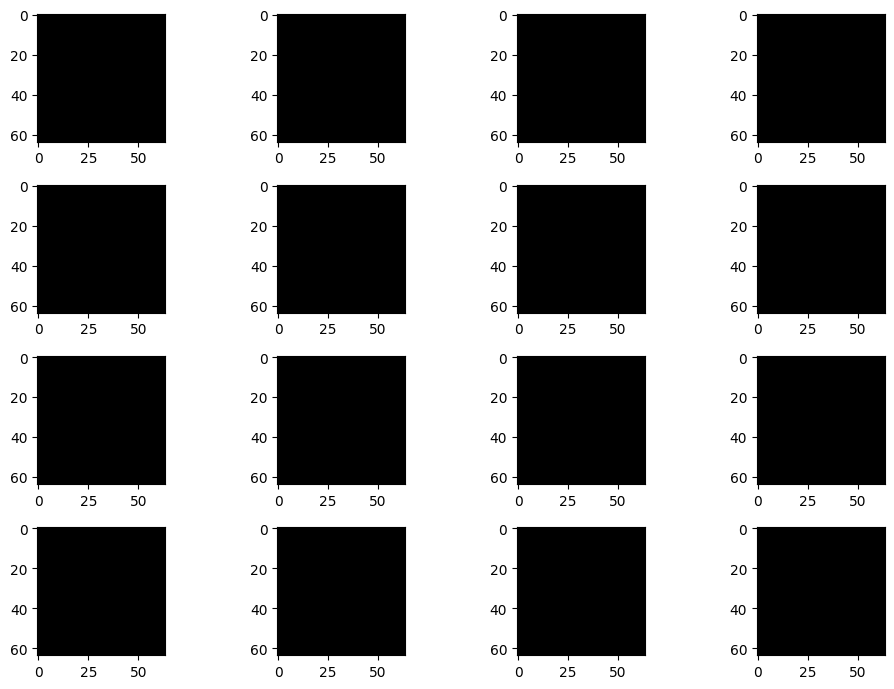

0it [00:00, ?it/s]

Epoch: 4, Gen Loss: 0.000035, Discriminator Loss: 0.000077


13it [01:41,  7.81s/it]


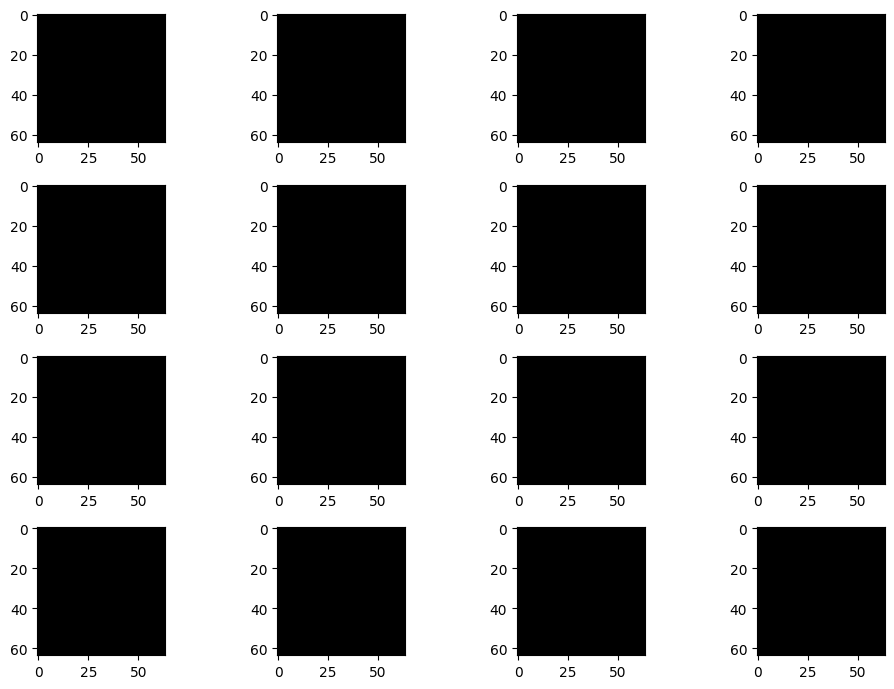

Epoch: 5, Gen Loss: 0.000021, Discriminator Loss: 0.000047


In [40]:
ev_noise = torch.randn(16, in_channel, 1, 1, device = device)

for epoch in range(1, epochs+1):
    s_g, s_d = 0., 0.
    
    gen.train()
    dc.train()
    for batch_idx, (contexts, targets) in tqdm(enumerate(train_loader)):
        
        contexts, targets = contexts.to(device), targets.to(device)
        contexts = contexts.transpose(3,1).float()/255
        
        # train the discriminator
        d_optimizer.zero_grad()
        
        # generate fake images and predict
        noise = torch.randn(contexts.shape[0], in_channel, 1, 1, device = device)
        f_img = gen(noise)
        f_pred = dc(f_img.detach())
        f_loss = F.binary_cross_entropy(f_pred.squeeze(-1).squeeze(-1), torch.zeros(contexts.shape[0]).to(device).unsqueeze(-1))
        
        # predict real images
        r_pred = dc(contexts)
        r_loss = F.binary_cross_entropy(r_pred.squeeze(-1).squeeze(-1), torch.ones(contexts.shape[0]).to(device).unsqueeze(-1))
        
        # backpropagate
        d_loss = f_loss + r_loss
        d_loss.backward()
        d_optimizer.step()
        
        # train the generator
        g_optimizer.zero_grad()
        g_pred = dc(f_img)
        g_loss = F.binary_cross_entropy(g_pred.squeeze(-1).squeeze(-1), torch.zeros(contexts.shape[0]).to(device).unsqueeze(-1))
        
        # backpropagate
        g_loss.backward()
        g_optimizer.step()
        
        # tally loss
        s_g += g_loss.item()
        s_d += d_loss.item()
    
    # visualize generated images after training
    with torch.no_grad():
        gen.eval()
        dc.eval()
        
        g_im = gen(torch.randn(contexts.shape[0], in_channel, 1, 1, device = device))
        g_im = torch.transpose(g_im, 1, 3)
        g_im = g_im.to(torch.uint8)*255
        
        rows, columns = 4, 4
        fig = plt.figure(figsize=(10, 7))
        
        for i in range(1, 17):
            fig.add_subplot(rows, columns, i)
            plt.imshow(g_im[i-1])

        plt.tight_layout()
        plt.show()
    
    print(f"Epoch: {epoch}, Gen Loss: {s_g/len(train_data):.6f}, Discriminator Loss: {s_d/len(train_data):.6f}")